In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#to plot accuracy
import cv2 as cv

import tensorflow as tf
from PIL import Image
import os
from keras.models import Model
from tensorflow import keras

from sklearn.model_selection import train_test_split #to split training and testing data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical #to convert the labels present in y_train and t_test into one-hot encoding
from keras.layers import Dense,  Dropout #to create CNN
%matplotlib inline

In [2]:
DATAPATH = r"TransferLearning/"

data = []
labels = []
classes = 4
cur_path = os.getcwd()
#Retrieving the images and their labels
for i in range(classes):
   path = os.path.join(DATAPATH,str(i))
   images = os.listdir(path)
   for a in images:
      try:
               image = Image.open(path + '/' + a)
               image = image.resize((30,30))
               image = np.array(image)
               image = image/255.0
               #sim = Image.fromarray(image)
               data.append(image)
               labels.append(i)
      except:
               print("Error loading image")
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

(451, 30, 30, 3) (451,)


In [3]:
#Splitting training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(383, 30, 30, 3) (68, 30, 30, 3) (383,) (68,)


In [4]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

In [5]:
image_generator = ImageDataGenerator(
                                        rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        brightness_range=[0.2,1.0],
                                        zoom_range=[0.5,1.0],
                                        featurewise_center=True,
                                        featurewise_std_normalization=True,
                                        )

image_generator.fit(x_train)

In [6]:
from keras.models import load_model
model = load_model("traffic_classifier_prueba.h5")

In [7]:
for i in range(5):
    model.layers[i].trainable = False

In [8]:
for i in range(6,7):
    model.layers[i].trainable = True

In [9]:
addl = model.layers[8].output
addl = Dense(32)(addl)
addl = Dense(16,activation='relu')(addl)
addl = Dense(16,activation='relu')(addl)
addl = Dense(16,activation='relu')(addl)
addl = Dense(8,activation='relu')(addl)
addl = Dense(4,activation="softmax")(addl)

new_model = Model(inputs=model.input,outputs=addl)

In [10]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 30, 30, 3)]      0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 64)          18496 

In [16]:
#train the model
with tf.device('/GPU:0'):
    epochs = 10
    history = new_model.fit(image_generator.flow(x_train, y_train, batch_size=16),
          steps_per_epoch=len(x_train) / 32, epochs=epochs)

Epoch 1/10
11/11 [==============================] - 0s 12ms/step - loss: 1.2922 - acc: 0.4398
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 1.2378 - acc: 0.4896
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 1.2362 - acc: 0.4817
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 1.2428 - acc: 0.4660
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 1.2204 - acc: 0.5079
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 1.2698 - acc: 0.4660
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 1.2417 - acc: 0.4792
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 1.2099 - acc: 0.4974
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 1.2722 - acc: 0.4479
Epoch 10/10
11/11 [==============================] - 0s 12ms/step - loss: 1.2837 - acc: 0.4398


In [18]:
new_model.save('transfer_learning_primer_modelo.h5')

TESTING DATA

In [2]:
model = load_model('transfer_learning_primer_modelo.h5')

In [3]:
import cv2 as cv
from statistics import mode

2
[[[148  74  53]]]
1/1 [==============================] - 0s 20ms/step
El número de la señal de tránsito es:  1


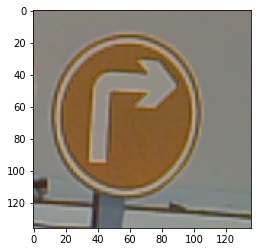

In [8]:
cropped = r"TransferLearning/Valid/1/27.png"
img = cv.imread(cropped)
#plt.imshow(img)

imgGray=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
imgGray = cv.medianBlur(imgGray, 5)
print(imgGray.ndim)
img_copy = imgGray.copy()
rows = img_copy.shape[0]

circles = cv.HoughCircles(img_copy,cv.HOUGH_GRADIENT,1,rows/8, 
                         		param1 = 30, param2 = 45, 
                         		minRadius = 50, maxRadius = 150)

if circles is not None:		#Condicional - si detecta circulos
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cy = i[0]
            cyv = cy
            for j in circles[0, :]:
                cx = j[1]
                center = (cx, cyv) 	
                radius = j[2]
                minrec = (cx - radius, cyv - radius)
                maxrec = (cx + radius, cyv + radius)
            
                print(circles)
                #plt.imshow(frame)

                frame = (img[(cx-radius-15):(cx+radius+15),(cyv-radius-15):(cyv+radius+15)])
                #plt.imshow(img)


                frameNN = cv.resize(frame,(30,30))

                tests = []
                tests.append(np.array(frameNN))
                X = np.array(tests)

                pred = np.argmax(model.predict(X))

                print("El número de la señal de tránsito es: ", pred)

                plt.imshow(frame)
